<a href="https://colab.research.google.com/github/aysimadeniz/AI-Object-Detection/blob/main/Copie_de_case_study_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-08370-4/MediaObjects/41586_2024_8370_MOESM3_ESM.zip

--2026-01-15 11:55:21--  https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-08370-4/MediaObjects/41586_2024_8370_MOESM3_ESM.zip
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89305224 (85M) [application/octet-stream]
Saving to: ‘41586_2024_8370_MOESM3_ESM.zip.1’

41586_2024_8370_MOE 100%[===================>]  85.17M   212MB/s    in 0.4s    

2026-01-15 11:55:21 (212 MB/s) - ‘41586_2024_8370_MOESM3_ESM.zip.1’ saved [89305224/89305224]



In [2]:

!unzip *.zip

Archive:  41586_2024_8370_MOESM3_ESM.zip
  inflating: 2024-04-08512B-s3/SupplementaryTable1.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable2.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable3.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable4.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable5.txt  


In [3]:
!mv *s3/* sample_data

In [4]:
!ls sample_data

anscombe.json		      mnist_train_small.csv    SupplementaryTable3.txt
california_housing_test.csv   README.md		       SupplementaryTable4.txt
california_housing_train.csv  SupplementaryTable1.txt  SupplementaryTable5.txt
mnist_test.csv		      SupplementaryTable2.txt


In [5]:
import polars as pl
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from transformers import AutoTokenizer, AutoModel
import torch
import h5py
from tqdm.autonotebook import tqdm
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import torch
import statsmodels.api as sm
import pandas as pd
import requests
from io import StringIO

In [6]:
df = pl.read_csv('/content/sample_data/SupplementaryTable5.txt', separator='\t', null_values='NA')
df

domain_ID,uniprot_ID,uniprot_ID_mutation,aa_seq,fitness,fitness_sigma,scaled_fitness,scaled_fitness_sigma,ESM1v_domain,RaSP,ddmut,FoldX,popEVE,EVE,Tranception,EVE_domain,rsasa,thermoMPNN,AlphaMissense,ESM1v_full-length,Organism,Gene Names (primary),Gene Names (synonym)
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,str,str,str,str
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28*""","""QIFVKTLMGKTITLEVELSDTIDNVK*KIQ…",0.059234,0.009105,-0.422846,0.1275171,null,null,null,null,null,null,null,null,41.3,null,null,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28C""","""QIFVKTLMGKTITLEVELSDTIDNVKCKIQ…",0.091262,0.003764,0.0257376,0.052712,-9.862297,0.944872,-0.14,0.865303,null,null,null,4.980072,41.3,-0.120494,0.334,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28D""","""QIFVKTLMGKTITLEVELSDTIDNVKDKIQ…",0.097388,0.003962,0.1115442,0.055491,-8.525545,0.344768,-0.01,0.975219,null,null,null,3.7665176,41.3,0.842978,0.279,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28E""","""QIFVKTLMGKTITLEVELSDTIDNVKEKIQ…",0.1101532,0.007189,0.2903249,0.1006934,-7.011676,-0.044519,0.05,0.703796,null,null,null,2.854782,41.3,0.355797,0.2014,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28F""","""QIFVKTLMGKTITLEVELSDTIDNVKFKIQ…",0.089583,0.003577,0.002225,0.050106,-10.680157,-0.423373,-0.44,0.0618476,null,null,null,5.208206,41.3,0.118878,0.3648,null,"""Homo sapiens (Human)""",null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104S""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.1054545,0.012201,-0.029589,0.137867,-5.345161,5.397289,-1.88,2.23219,null,null,null,8.343338,11.8,2.117514,0.9588,"""-12.64865""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104T""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.090854,0.015305,-0.194564,0.1729378,-5.214868,4.558003,-1.69,1.77879,null,null,null,9.494637,11.8,1.988062,0.9647,"""-14.00641""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104V""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.1158156,0.010449,0.087485,0.1180705,-4.870904,3.148088,-1.42,1.52182,null,null,null,8.973549,11.8,1.270481,0.9512,"""-13.55418""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""


In [7]:
df_subset = (
    df
    .filter(pl.col('Organism') == "Homo sapiens (Human)")
    .filter(~pl.col('aa_seq').str.contains('\*'))
    .select(['domain_ID', 'uniprot_ID', 'uniprot_ID_mutation', 'aa_seq', 'scaled_fitness'])
  )

<>:4: SyntaxWarning: invalid escape sequence '\*'
<>:4: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipython-input-2770699436.py:4: SyntaxWarning: invalid escape sequence '\*'


In [8]:
df_correlation = (
    df
    .filter(pl.col('Organism') == "Homo sapiens (Human)")
    .filter(~pl.col('aa_seq').str.contains(r'\*'))
    .select(['uniprot_ID_mutation', 'scaled_fitness', 'AlphaMissense', 'ESM1v_domain', 'EVE_domain'])
    .with_columns(pl.col('EVE_domain').cast(pl.Float64))
    .drop_nulls()
    .with_columns(pl.col('uniprot_ID_mutation').str.split_exact('_', 1).struct[0].alias('uniprot_ID'))
)
df_correlation.head()

uniprot_ID_mutation,scaled_fitness,AlphaMissense,ESM1v_domain,EVE_domain,uniprot_ID
str,f64,f64,f64,f64,str
"""A0A2R8Y422_A28C""",0.0257376,0.334,-9.862297,4.980072,"""A0A2R8Y422"""
"""A0A2R8Y422_A28D""",0.1115442,0.279,-8.525545,3.7665176,"""A0A2R8Y422"""
"""A0A2R8Y422_A28E""",0.2903249,0.2014,-7.011676,2.854782,"""A0A2R8Y422"""
"""A0A2R8Y422_A28F""",0.002225,0.3648,-10.680157,5.208206,"""A0A2R8Y422"""
"""A0A2R8Y422_A28G""",-0.033329,0.1135,-7.925185,4.270241,"""A0A2R8Y422"""


In [9]:
seq_df = df_subset.drop_nans().drop_nulls().head(1000) \
.with_columns(pl.col('aa_seq').str.replace('\*', '')) \
.select(['uniprot_ID_mutation', 'aa_seq', 'scaled_fitness']) \
.unique('uniprot_ID_mutation')

seq_df = (
    df_subset
    .drop_nans().drop_nulls()
    .sample(n=10_000, seed=7)
    # .with_columns(pl.col('aa_seq').str.replace('\*', ''))
    .select(['uniprot_ID_mutation', 'aa_seq', 'scaled_fitness'])
    .unique('uniprot_ID_mutation')
)

<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipython-input-3483898395.py:2: SyntaxWarning: invalid escape sequence '\*'


In [10]:
alpha_missense_corr = df_correlation.select(pl.corr(pl.col('scaled_fitness'), pl.col('AlphaMissense'), method='spearman')).item()
esm1v_domain_corr = df_correlation.select(pl.corr(pl.col('scaled_fitness'), pl.col('ESM1v_domain'), method='spearman')).item()
eve_domain_corr = df_correlation.select(pl.corr(pl.col('scaled_fitness'), pl.col('EVE_domain'), method='spearman')).item()

print(f"Absolute Global Spearman Correlation (scaled_fitness vs. AlphaMissense): {abs(alpha_missense_corr):.4f}")
print(f"Absolute Global Spearman Correlation (scaled_fitness vs. ESM1v_domain): {abs(esm1v_domain_corr):.4f}")
print(f"Absolute Global Spearman Correlation (scaled_fitness vs. EVE_domain): {abs(eve_domain_corr):.4f}")

Absolute Global Spearman Correlation (scaled_fitness vs. AlphaMissense): 0.3244
Absolute Global Spearman Correlation (scaled_fitness vs. ESM1v_domain): 0.3587
Absolute Global Spearman Correlation (scaled_fitness vs. EVE_domain): 0.4226


In [11]:
protein_correlations = df_correlation.group_by('uniprot_ID').agg(
    pl.corr('scaled_fitness', 'AlphaMissense', method='spearman').alias('AlphaMissense_Spearman'),
    pl.corr('scaled_fitness', 'ESM1v_domain', method='spearman').alias('ESM1v_domain_Spearman'),
    pl.corr('scaled_fitness', 'EVE_domain', method='spearman').alias('EVE_domain_Spearman')
)
protein_correlations.head()

uniprot_ID,AlphaMissense_Spearman,ESM1v_domain_Spearman,EVE_domain_Spearman
str,f64,f64,f64
"""Q96J02""",-0.41626,0.50228,-0.538361
"""Q00987""",-0.378427,0.642943,-0.442044
"""P08151""",-0.127054,0.056056,-0.378222
"""P22681""",-0.309355,0.559956,-0.372584
"""Q7Z6B7""",-0.506448,0.544512,-0.538801


/tmp/ipython-input-2574261844.py:7: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


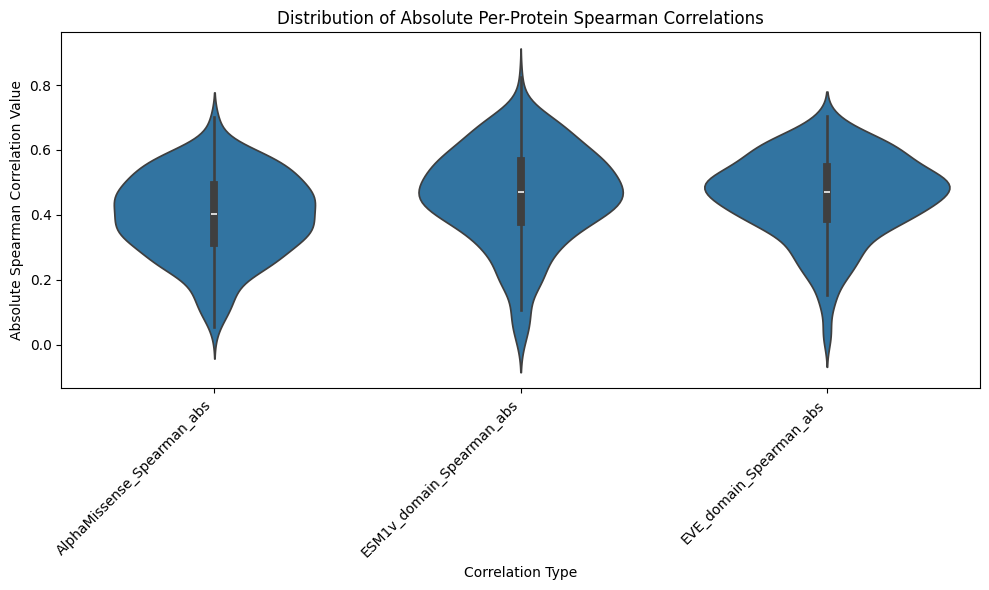

In [12]:
protein_correlations_abs = protein_correlations.with_columns(
    pl.col('AlphaMissense_Spearman').abs().alias('AlphaMissense_Spearman_abs'),
    pl.col('ESM1v_domain_Spearman').abs().alias('ESM1v_domain_Spearman_abs'),
    pl.col('EVE_domain_Spearman').abs().alias('EVE_domain_Spearman_abs')
)

protein_correlations_melted_abs = protein_correlations_abs.melt(
    id_vars=['uniprot_ID'],
    value_vars=['AlphaMissense_Spearman_abs', 'ESM1v_domain_Spearman_abs', 'EVE_domain_Spearman_abs'],
    variable_name='Correlation_Type',
    value_name='Absolute_Spearman_Correlation_Value'
)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.violinplot(x='Correlation_Type', y='Absolute_Spearman_Correlation_Value', data=protein_correlations_melted_abs.to_pandas(), ax=axes)
axes.set_title('Distribution of Absolute Per-Protein Spearman Correlations')
axes.set_xlabel('Correlation Type')
axes.set_ylabel('Absolute Spearman Correlation Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
protein_correlations = protein_correlations.with_columns(
    pl.col('AlphaMissense_Spearman').abs().alias('AlphaMissense_Spearman_abs'),
    pl.col('ESM1v_domain_Spearman').abs().alias('ESM1v_domain_Spearman_abs'),
    pl.col('EVE_domain_Spearman').abs().alias('EVE_domain_Spearman_abs')
)

protein_correlations = protein_correlations.with_columns(
    pl.max_horizontal(['AlphaMissense_Spearman_abs', 'ESM1v_domain_Spearman_abs', 'EVE_domain_Spearman_abs']).alias('mean_abs_spearman_corr')
)

protein_correlations_sorted = protein_correlations.sort('mean_abs_spearman_corr', descending=True)

num_proteins = protein_correlations_sorted.shape[0]
top_50_percent_count = num_proteins // 2

selected_protein_ids = protein_correlations_sorted.head(top_50_percent_count)['uniprot_ID'].to_list()

print(f"Total number of proteins: {num_proteins}")
print(f"Number of proteins selected (top 50%): {top_50_percent_count}")
print(f"First 5 selected protein IDs: {selected_protein_ids[:5]}")

Total number of proteins: 415
Number of proteins selected (top 50%): 207
First 5 selected protein IDs: ['Q5TCQ9', 'P14598', 'Q9GZV5', 'Q14CM0', 'Q9Y6N9']


In [14]:
seq_df_refined = seq_df.filter(pl.col('uniprot_ID_mutation').str.split_exact('_', 1).struct[0].is_in(selected_protein_ids))
seq_df_refined.head()

uniprot_ID_mutation,aa_seq,scaled_fitness
str,str,f64
"""P15056_I208G""","""QKPIVRVFLPNKQRTVVPARCGVTVRDSLK…",-0.487776
"""Q9UQR1_A178V""","""VCEHCNVAFRTNYHLQRHVFIH""",-0.337219
"""Q96KC8_E506D""","""EEPWTQNQQKLLDLALQQYPRGSSDRWDKI…",-0.044372
"""Q86UL8_I321V""","""EDNEEPDPLPDNWEMAYTEKGEVYFVDHNT…",0.009553
"""O75112_K68W""","""MSYSVTLTGPGPWGFRLQGGKDFNMPLTIS…",-0.108037


In [15]:
esm2_model_path = 'facebook/esm2_t33_650M_UR50D'
tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [16]:
inputs_refined = tokenizer(list(seq_df_refined['aa_seq']), return_tensors="pt", padding=True, truncation=True, max_length=300)
print(f"Tokenized sequences for {len(inputs_refined['input_ids'])} proteins.")
model = AutoModel.from_pretrained(esm2_model_path)


Tokenized sequences for 5103 proteins.


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------------------------------------

Using ESM2 on new dataset to get embeddings






In [17]:
torch.cuda.empty_cache()
batch_size = 256
res_dict_refined = {}
fitness_list_refined = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i in tqdm(range(0, len(inputs_refined["input_ids"]), batch_size)):
    batch_input_ids = inputs_refined['input_ids'][i:i+batch_size].to(device)
    batch_attention_mask = inputs_refined['attention_mask'][i:i+batch_size].to(device)

    batch_seq_ids = seq_df_refined[i:i+batch_size]['uniprot_ID_mutation'].to_list()
    batch_fitness = seq_df_refined[i:i+batch_size]['scaled_fitness'].to_list()

    with torch.no_grad():
        with torch.autocast('cuda'):
            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)['last_hidden_state'].float()

            for j in range(output.shape[0]):
                embedding = output[j][batch_attention_mask[j].bool(), :].detach().half().cpu()
                averaged = embedding.mean(axis=0)
                res_dict_refined[batch_seq_ids[j]] = averaged.numpy()
                fitness_list_refined.append(batch_fitness[j])

print(f"Generated embeddings for {len(res_dict_refined)} proteins.")

  0%|          | 0/20 [00:00<?, ?it/s]

Generated embeddings for 5103 proteins.


In [18]:
groups_refined = np.array([k.split('_')[0] for k in res_dict_refined.keys()])
X_refined = np.vstack(list(res_dict_refined.values()))
y_refined = np.array(fitness_list_refined)

print(f"Shape of X_refined: {X_refined.shape}")
print(f"Shape of y_refined: {y_refined.shape}")
print(f"Shape of groups_refined: {groups_refined.shape}")
print(f"Number of unique proteins in refined data: {len(np.unique(groups_refined))}")

Shape of X_refined: (5103, 1280)
Shape of y_refined: (5103,)
Shape of groups_refined: (5103,)
Number of unique proteins in refined data: 207


In [19]:
X_refined_scaled = StandardScaler().fit_transform(X_refined)
print(f"Shape of X_refined_scaled: {X_refined_scaled.shape}")


Shape of X_refined_scaled: (5103, 1280)


In [20]:
gss_refined = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx_refined, test_idx_refined = next(gss_refined.split(X_refined_scaled, y_refined, groups=groups_refined))

X_train_refined = X_refined_scaled[train_idx_refined]
X_test_refined = X_refined_scaled[test_idx_refined]
y_train_refined = y_refined[train_idx_refined]
y_test_refined = y_refined[test_idx_refined]

print(f"Shape of X_train_refined: {X_train_refined.shape}")
print(f"Shape of X_test_refined: {X_test_refined.shape}")
print(f"Shape of y_train_refined: {y_train_refined.shape}")
print(f"Shape of y_test_refined: {y_test_refined.shape}")

Shape of X_train_refined: (3754, 1280)
Shape of X_test_refined: (1349, 1280)
Shape of y_train_refined: (3754,)
Shape of y_test_refined: (1349,)




---
Applying Ridge regressor to the embeddings to get a scaled_fitness


R-squared on refined test set: -0.8350


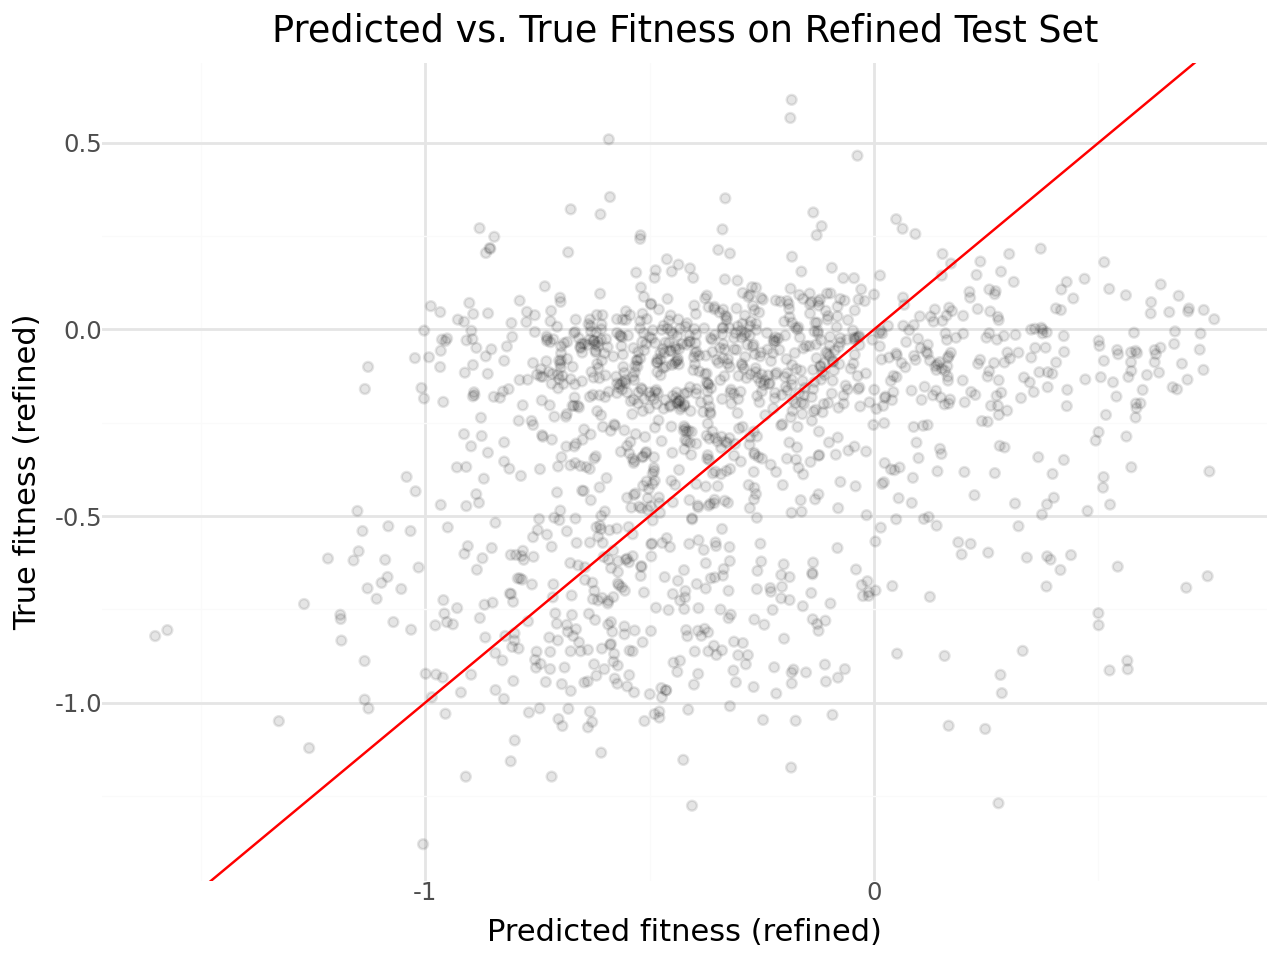

In [21]:
ridge_model_refined = Ridge(alpha=100.0)
ridge_model_refined.fit(X_train_refined, y_train_refined)

y_test_pred_refined = ridge_model_refined.predict(X_test_refined)
r2_refined = r2_score(y_test_refined, y_test_pred_refined)

print(f"R-squared on refined test set: {r2_refined:.4f}")

(
    ggplot(pl.DataFrame({'y_test_refined': y_test_refined, 'y_test_pred_refined': y_test_pred_refined}), aes(x='y_test_pred_refined', y='y_test_refined'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness (refined)', y='True fitness (refined)', title='Predicted vs. True Fitness on Refined Test Set')
    + theme_minimal()
)

In [22]:
from scipy.stats import spearmanr

In [23]:
spearman_corr, _ = spearmanr(y_test_refined, y_test_pred_refined)
abs_spearman_corr = abs(spearman_corr)

print(f"Absolute Spearman Correlation on refined test set: {abs_spearman_corr:.4f}")

Absolute Spearman Correlation on refined test set: 0.2567




---
ESM2 with new features : Score of the other models as features (inspiration from Yun Song paper)


In [24]:
df_correlation = (
    df
    .filter(pl.col('Organism') == "Homo sapiens (Human)")
    .filter(~pl.col('aa_seq').str.contains(r'\*'))
    .select(['uniprot_ID_mutation', 'scaled_fitness', 'AlphaMissense', 'ESM1v_domain', 'EVE_domain'])
    .with_columns(pl.col('EVE_domain').cast(pl.Float64))
    .drop_nulls()
    .with_columns(pl.col('uniprot_ID_mutation').str.split_exact('_', 1).struct[0].alias('uniprot_ID'))
)

esm2_embedding_map = {
    k: X_refined_scaled[i]
    for i, k in enumerate(list(res_dict_refined.keys()))
}

current_refined_data = pl.DataFrame({
    'uniprot_ID_mutation': list(res_dict_refined.keys()),
    'scaled_fitness': fitness_list_refined
})

additional_features_to_merge = df_correlation.select(['uniprot_ID_mutation', 'AlphaMissense', 'ESM1v_domain', 'EVE_domain'])

combined_data_for_features = current_refined_data.join(
    additional_features_to_merge,
    on='uniprot_ID_mutation',
    how='inner'
)

final_uniprot_mut_ids = combined_data_for_features['uniprot_ID_mutation'].to_list()

X_refined_final_embeddings = np.vstack([esm2_embedding_map[uid] for uid in final_uniprot_mut_ids])

y_combined = combined_data_for_features['scaled_fitness'].to_numpy()

additional_features_matrix = combined_data_for_features.select(['AlphaMissense', 'ESM1v_domain', 'EVE_domain']).to_numpy()

X_combined_raw = np.hstack([X_refined_final_embeddings, additional_features_matrix])

groups_combined = np.array([k.split('_')[0] for k in final_uniprot_mut_ids])

print(f"Shape of X_combined_raw: {X_combined_raw.shape}")
print(f"Shape of y_combined: {y_combined.shape}")
print(f"Shape of groups_combined: {groups_combined.shape}")
print(f"Number of unique proteins in combined data: {len(np.unique(groups_combined))}")

Shape of X_combined_raw: (5288, 1283)
Shape of y_combined: (5288,)
Shape of groups_combined: (5288,)
Number of unique proteins in combined data: 207


In [25]:
scaler_for_combined_features = StandardScaler()
X_combined_scaled = scaler_for_combined_features.fit_transform(X_combined_raw)

gss_combined = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx_combined, test_idx_combined = next(gss_combined.split(X_combined_scaled, y_combined, groups=groups_combined))

X_train_combined = X_combined_scaled[train_idx_combined]
X_test_combined = X_combined_scaled[test_idx_combined]
y_train_combined = y_combined[train_idx_combined]
y_test_combined = y_combined[test_idx_combined]

print(f"\nShape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of X_test_combined: {X_test_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")
print(f"Shape of y_test_combined: {y_test_combined.shape}")


Shape of X_train_combined: (3845, 1283)
Shape of X_test_combined: (1443, 1283)
Shape of y_train_combined: (3845,)
Shape of y_test_combined: (1443,)


In [26]:
ridge_model_combined = Ridge(alpha=100.0)
ridge_model_combined.fit(X_train_combined, y_train_combined)

y_test_pred_combined = ridge_model_combined.predict(X_test_combined)
r2_combined = r2_score(y_test_combined, y_test_pred_combined)

print(f"\nR-squared on combined test set (ESM2 + other features): {r2_combined:.4f}")


R-squared on combined test set (ESM2 + other features): -0.1677


In [27]:
combined_plot = (
    ggplot(pl.DataFrame({'y_true': y_test_combined, 'y_pred': y_test_pred_combined}), aes(x='y_pred', y='y_true'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness (ESM2 + other features)', y='True fitness', title='Predicted vs. True Fitness on Combined Test Set')
    + theme_minimal()
)
print(combined_plot)

<ggplot: (640 x 480)>


In [28]:

spearman_corr_combined, _ = spearmanr(y_test_combined, y_test_pred_combined)
abs_spearman_corr_combined = abs(spearman_corr_combined)

print(f"Absolute Spearman Correlation on combined test set (ESM2 + other features): {abs_spearman_corr_combined:.4f}")

Absolute Spearman Correlation on combined test set (ESM2 + other features): 0.4060


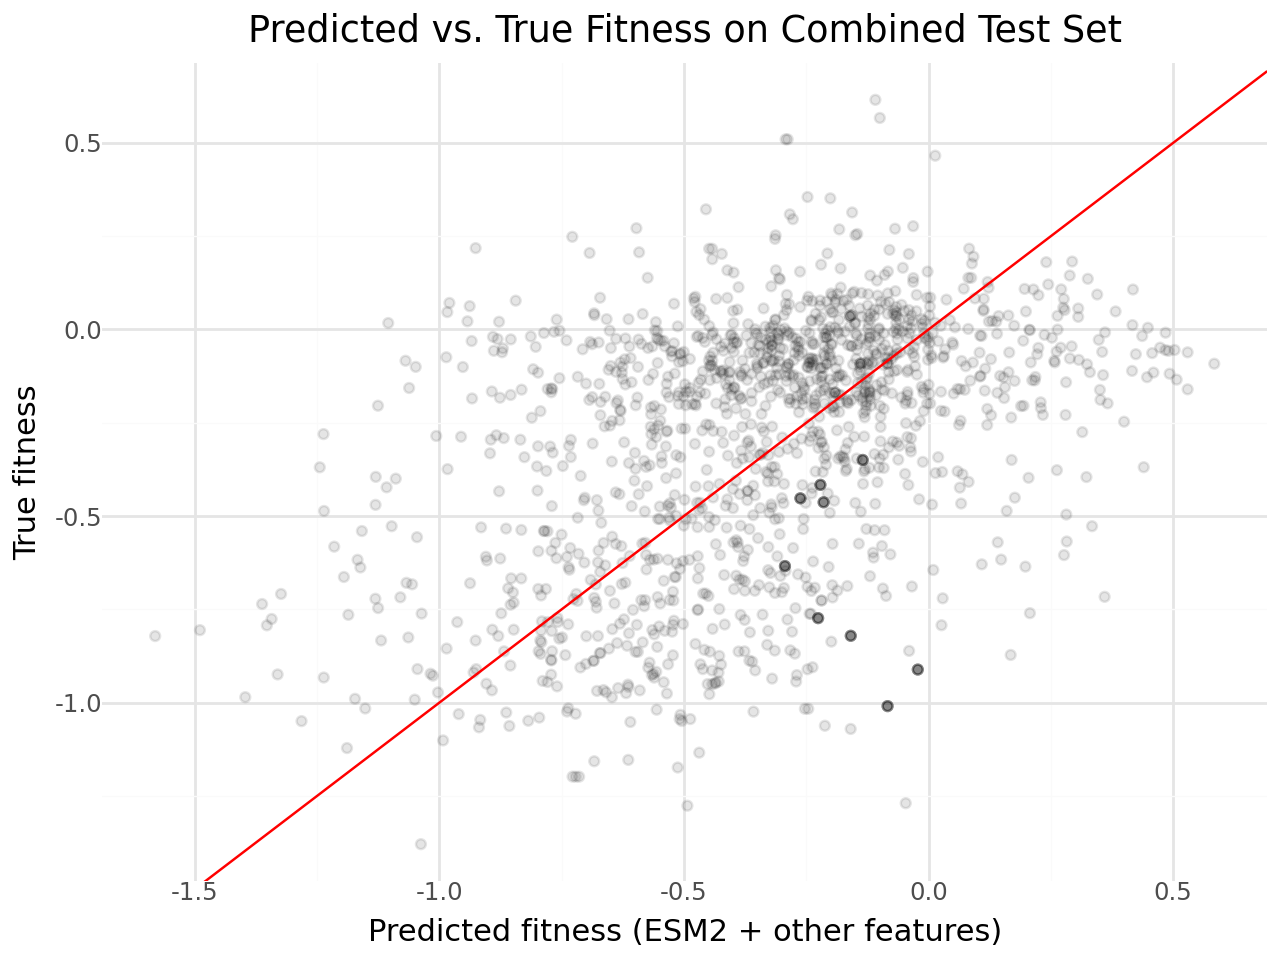

In [29]:
display(combined_plot)

In [30]:


proteins_in_test_set = groups_combined[test_idx_combined]

protein_results_df = pl.DataFrame({
    'uniprot_ID': proteins_in_test_set,
    'true_fitness': y_test_combined,
    'predicted_fitness': y_test_pred_combined
})

def calculate_spearman_for_group(group_df: pl.DataFrame) -> float:
    if group_df.height < 2:
        return float('nan')
    return spearmanr(group_df['true_fitness'].to_numpy(), group_df['predicted_fitness'].to_numpy()).correlation

per_protein_spearman_df_list = []
for group_name, group_df in protein_results_df.group_by('uniprot_ID'):
    corr = calculate_spearman_for_group(group_df)
    per_protein_spearman_df_list.append(pl.DataFrame({
        'uniprot_ID': [group_name],
        'spearman_correlation': [corr]
    }))

per_protein_spearman = pl.concat(per_protein_spearman_df_list)

per_protein_spearman_pd = per_protein_spearman.to_pandas()
per_protein_spearman_pd['abs_spearman_correlation'] = per_protein_spearman_pd['spearman_correlation'].abs().dropna() # dropna() to handle proteins with < 2 mutations resulting in NaN spearman correlation

print(per_protein_spearman_pd.head())


  uniprot_ID  spearman_correlation  abs_spearman_correlation
0   [Q13263]              0.482456                  0.482456
1   [Q9BV68]              0.664286                  0.664286
2   [Q9UHD4]              0.647179                  0.647179
3   [Q9UKW6]              0.676923                  0.676923
4   [P67809]              0.381955                  0.381955


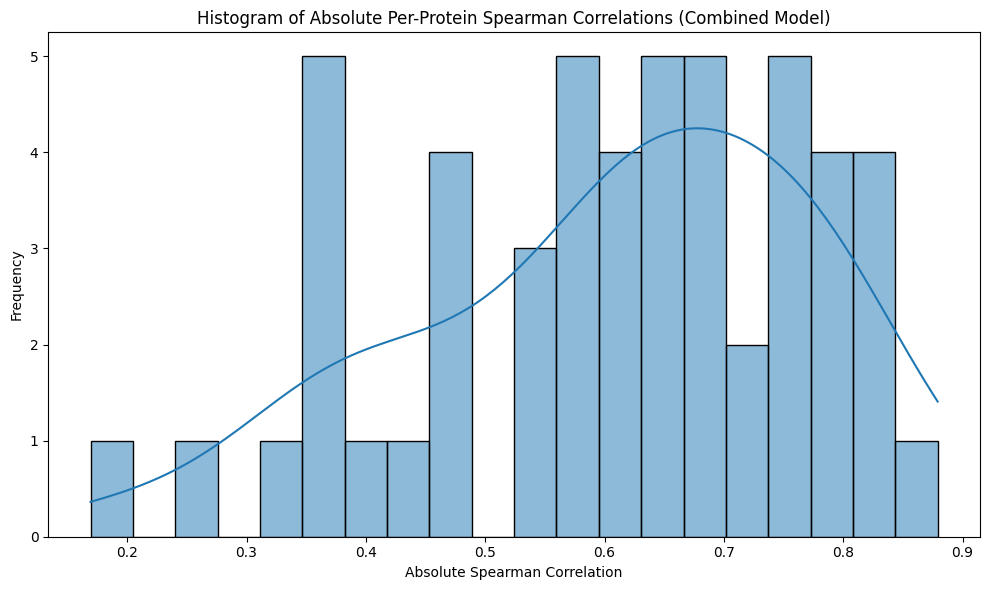

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(per_protein_spearman_pd['abs_spearman_correlation'], bins=20, kde=True)
plt.title('Histogram of Absolute Per-Protein Spearman Correlations (Combined Model)')
plt.xlabel('Absolute Spearman Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [32]:

y = y_combined
X = X_combined_scaled

X = sm.add_constant(X)

model_ols = sm.OLS(y, X)
results_ols = model_ols.fit()

print(results_ols.summary())


p_values_array = results_ols.pvalues


feature_names = ['const'] + [f'x{i}' for i in range(1, len(p_values_array))]

p_values = pd.Series(p_values_array, index=feature_names)


p_values_features = p_values.drop('const')

sorted_p_values = p_values_features.sort_values(ascending=True)

top_5_features = sorted_p_values.head(5)

print("\nTop 5 Features by p-value (lowest first):\n")
for feature_name, p_value in top_5_features.items():


      print(f"Feature: ESM2 embedding dimension {feature_name[1:]} (p-value: {p_value:.4e})")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     5.659
Date:                Thu, 15 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:57:26   Log-Likelihood:                 979.13
No. Observations:                5288   AIC:                             609.7
Df Residuals:                    4004   BIC:                             9050.
Df Model:                        1283                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2963      0.003    -93.236      0.0



---

New feature added to ESM2 : Comparisons between variant and referent protein.

In [33]:
unique_uniprot_ids_refined = seq_df_refined['uniprot_ID_mutation'].str.split_exact('_', 1).struct[0].unique().to_list()

reference_df = (
    df_subset
    .filter(
        (pl.col('uniprot_ID').is_in(unique_uniprot_ids_refined)) &
        (pl.col('uniprot_ID_mutation').str.contains('NANANA'))
    )
    .select(['uniprot_ID', 'aa_seq'])
    .unique('uniprot_ID')
)

print(f"Found {reference_df.shape[0]} unique reference protein sequences.")


reference_inputs = tokenizer(list(reference_df['aa_seq']), return_tensors="pt", padding=True, truncation=True, max_length=300)
print(f"Tokenized {len(reference_inputs['input_ids'])} reference sequences.")

reference_embeddings_dict = {}
reference_batch_size = 256

for i in tqdm(range(0, len(reference_inputs["input_ids"]), reference_batch_size)):
    batch_input_ids = reference_inputs['input_ids'][i:i+reference_batch_size].to(device)
    batch_attention_mask = reference_inputs['attention_mask'][i:i+reference_batch_size].to(device)
    batch_uniprot_ids = reference_df[i:i+reference_batch_size]['uniprot_ID'].to_list()

    with torch.no_grad():
        with torch.autocast('cuda'):
            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)['last_hidden_state'].float()

            for j in range(output.shape[0]):

                embedding = output[j][batch_attention_mask[j].bool(), :].detach().half().cpu()
                averaged = embedding.mean(axis=0)
                reference_embeddings_dict[batch_uniprot_ids[j]] = averaged.numpy()

print(f"Generated embeddings for {len(reference_embeddings_dict)} reference proteins.")

Found 207 unique reference protein sequences.
Tokenized 207 reference sequences.


  0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings for 207 reference proteins.


In [34]:
l2_distances = []

uniprot_id_mapping = {
    k: k.split('_')[0] for k in res_dict_refined.keys()
}

for variant_id, variant_embedding in tqdm(res_dict_refined.items()):
    uniprot_id = uniprot_id_mapping[variant_id]
    if uniprot_id in reference_embeddings_dict:
        reference_embedding = reference_embeddings_dict[uniprot_id]

        distance = np.linalg.norm(variant_embedding - reference_embedding)
        l2_distances.append(distance)
    else:

        l2_distances.append(np.nan)


l2_distances_array = np.array(l2_distances)
print(f"Calculated L2 distances for {len(l2_distances_array)} variant proteins.")

  0%|          | 0/5103 [00:00<?, ?it/s]

Calculated L2 distances for 5103 variant proteins.


In [35]:
l2_distances_map = {k: l2_distances_array[i] for i, k in enumerate(list(res_dict_refined.keys()))}

l2_distances_for_combined_X = np.array([l2_distances_map[uid] for uid in final_uniprot_mut_ids])

l2_distances_for_combined_X = l2_distances_for_combined_X.reshape(-1, 1)

X_combined_with_l2_raw = np.hstack([X_refined_final_embeddings, l2_distances_for_combined_X])

scaler_for_combined_with_l2 = StandardScaler()
X_combined_with_l2_scaled = scaler_for_combined_with_l2.fit_transform(X_combined_with_l2_raw)

groups_combined_with_l2 = np.array([k.split('_')[0] for k in final_uniprot_mut_ids])

gss_combined_with_l2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx_combined_with_l2, test_idx_combined_with_l2 = next(gss_combined_with_l2.split(X_combined_with_l2_scaled, y_combined, groups=groups_combined_with_l2))

X_train_combined_with_l2 = X_combined_with_l2_scaled[train_idx_combined_with_l2]
X_test_combined_with_l2 = X_combined_with_l2_scaled[test_idx_combined_with_l2]
y_train_combined_with_l2 = y_combined[train_idx_combined_with_l2]
y_test_combined_with_l2 = y_combined[test_idx_combined_with_l2]

print(f"Shape of X_combined_with_l2_raw: {X_combined_with_l2_raw.shape}")
print(f"Shape of X_combined_with_l2_scaled: {X_combined_with_l2_scaled.shape}")
print(f"Shape of X_train_combined_with_l2: {X_train_combined_with_l2.shape}")
print(f"Shape of X_test_combined_with_l2: {X_test_combined_with_l2.shape}")
print(f"Shape of y_train_combined_with_l2: {y_train_combined_with_l2.shape}")
print(f"Shape of y_test_combined_with_l2: {y_test_combined_with_l2.shape}")


Shape of X_combined_with_l2_raw: (5288, 1281)
Shape of X_combined_with_l2_scaled: (5288, 1281)
Shape of X_train_combined_with_l2: (3845, 1281)
Shape of X_test_combined_with_l2: (1443, 1281)
Shape of y_train_combined_with_l2: (3845,)
Shape of y_test_combined_with_l2: (1443,)


In [36]:
ridge_model_combined_with_l2 = Ridge(alpha=100.0)
ridge_model_combined_with_l2.fit(X_train_combined_with_l2, y_train_combined_with_l2)

y_test_pred_combined_with_l2 = ridge_model_combined_with_l2.predict(X_test_combined_with_l2)
r2_combined_with_l2 = r2_score(y_test_combined_with_l2, y_test_pred_combined_with_l2)

print(f"\nR-squared on combined test set (ESM2  + L2 distance): {r2_combined_with_l2:.4f}")

spearman_corr_combined_with_l2, _ = spearmanr(y_test_combined_with_l2, y_test_pred_combined_with_l2)
abs_spearman_corr_combined_with_l2 = abs(spearman_corr_combined_with_l2)

print(f"Absolute Spearman Correlation on combined test set (ESM2  + L2 distance): {abs_spearman_corr_combined_with_l2:.4f}")

r2_comparison_l2 = "improved" if r2_combined_with_l2 > r2_combined else "did not improve"
spearman_comparison_l2 = "improved" if abs_spearman_corr_combined_with_l2 > abs_spearman_corr_combined else "did not improve"

print(f"R-squared {r2_comparison_l2} with L2 distance feature (Previous: {r2_combined:.4f}, New: {r2_combined_with_l2:.4f})")
print(f"Absolute Spearman Correlation {spearman_comparison_l2} with L2 distance feature (Previous: {abs_spearman_corr_combined:.4f}, New: {abs_spearman_corr_combined_with_l2:.4f})")



R-squared on combined test set (ESM2  + L2 distance): -0.8194
Absolute Spearman Correlation on combined test set (ESM2  + L2 distance): 0.2404
R-squared did not improve with L2 distance feature (Previous: -0.1677, New: -0.8194)
Absolute Spearman Correlation did not improve with L2 distance feature (Previous: 0.4060, New: 0.2404)


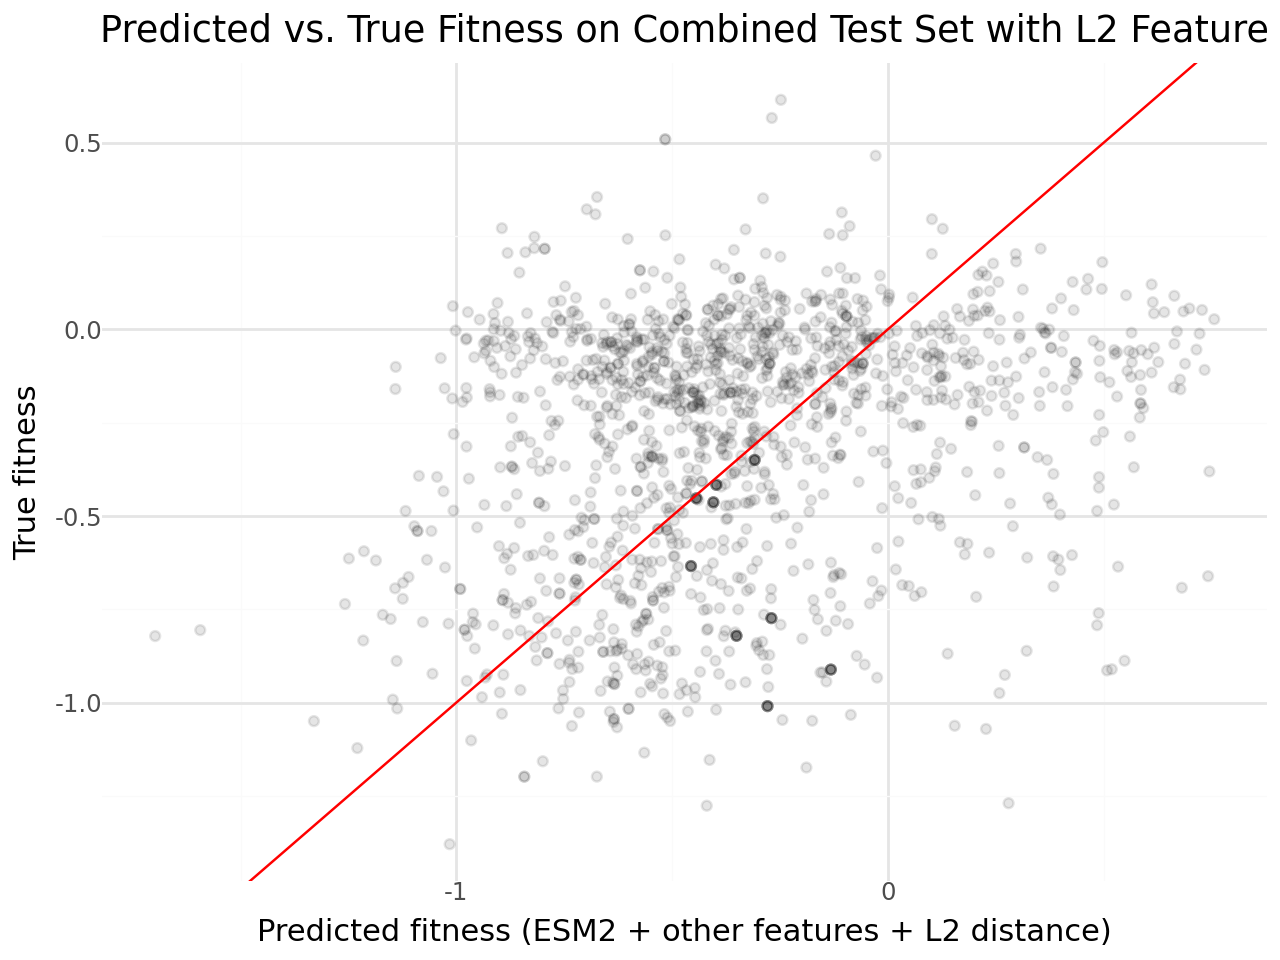

In [37]:
combined_plot_l2 = (
    ggplot(pl.DataFrame({'y_true': y_test_combined_with_l2, 'y_pred': y_test_pred_combined_with_l2}), aes(x='y_pred', y='y_true'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness (ESM2 + other features + L2 distance)', y='True fitness', title='Predicted vs. True Fitness on Combined Test Set with L2 Feature')
    + theme_minimal()
)
display(combined_plot_l2)

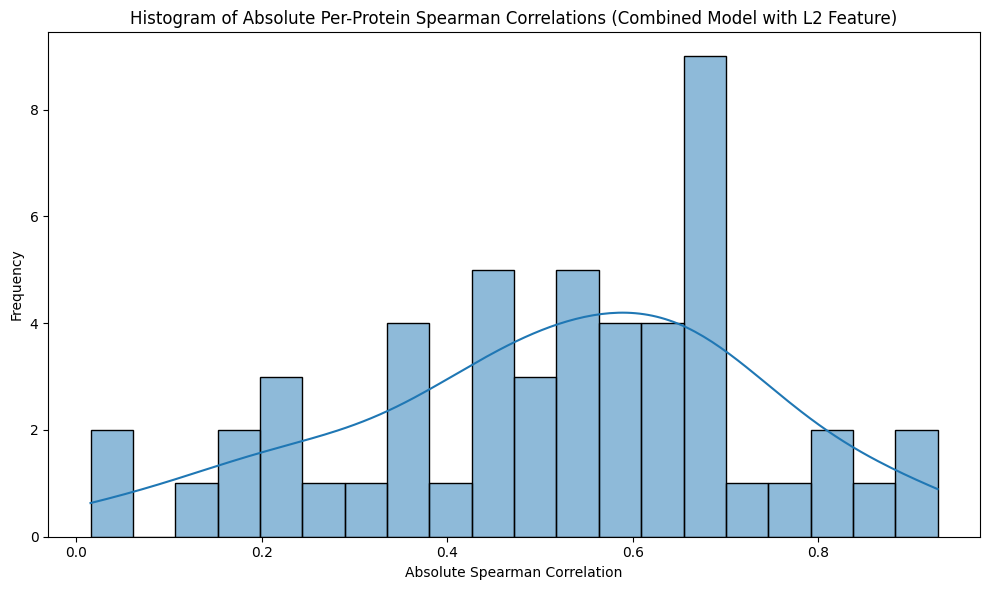

In [38]:
proteins_in_test_set_l2 = groups_combined_with_l2[test_idx_combined_with_l2]

protein_results_df_l2 = pl.DataFrame({
    'uniprot_ID': proteins_in_test_set_l2,
    'true_fitness': y_test_combined_with_l2,
    'predicted_fitness': y_test_pred_combined_with_l2
})

per_protein_spearman_df_list_l2 = []
for group_name, group_df in protein_results_df_l2.group_by('uniprot_ID'):
    corr = calculate_spearman_for_group(group_df)
    per_protein_spearman_df_list_l2.append(pl.DataFrame({
        'uniprot_ID': [group_name],
        'spearman_correlation': [corr]
    }))

per_protein_spearman_l2 = pl.concat(per_protein_spearman_df_list_l2)

per_protein_spearman_pd_l2 = per_protein_spearman_l2.to_pandas()
per_protein_spearman_pd_l2['abs_spearman_correlation'] = per_protein_spearman_pd_l2['spearman_correlation'].abs().dropna()

plt.figure(figsize=(10, 6))
sns.histplot(per_protein_spearman_pd_l2['abs_spearman_correlation'], bins=20, kde=True)
plt.title('Histogram of Absolute Per-Protein Spearman Correlations (Combined Model with L2 Feature)')
plt.xlabel('Absolute Spearman Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [39]:

y = y_combined
X = X_combined_with_l2_scaled

X = sm.add_constant(X)

model_ols = sm.OLS(y, X)
results_ols = model_ols.fit()

print(results_ols.summary())


p_values_array = results_ols.pvalues


feature_names = ['const'] + [f'x{i}' for i in range(1, len(p_values_array))]

p_values = pd.Series(p_values_array, index=feature_names)


p_values_features = p_values.drop('const')

sorted_p_values = p_values_features.sort_values(ascending=True)

top_5_features = sorted_p_values.head(5)

print("\nTop 5 Features by p-value (lowest first):\n")
for feature_name, p_value in top_5_features.items():
    if feature_name == 'x1281':
        print(f"Feature: L2 Score (p-value: {p_value:.4e})")
    else:

        print(f"Feature: ESM2 embedding dimension {feature_name[1:]} (p-value: {p_value:.4e})")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     4.384
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          4.88e-279
Time:                        11:57:37   Log-Likelihood:                 561.06
No. Observations:                5288   AIC:                             1442.
Df Residuals:                    4006   BIC:                             9869.
Df Model:                        1281                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2960      0.003    -84.847      0.0



---
New feature added to ESM2 : Log odd between alt and ref variant


In [40]:
BLOSUM62_MATRIX = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': -1, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': -1, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}


In [41]:
def calculate_log_odds_for_mutation_dynamic_pos(wt_sequence, var_sequence, blosum62_matrix):
    """
    Calculates the log odds score for a single point mutation by dynamically
    identifying the mutation position from two sequences.

    Args:
        wt_sequence (str): The wild-type amino acid sequence.
        var_sequence (str): The variant amino acid sequence.
        blosum62_matrix (dict): The BLOSUM62 substitution matrix.

    Returns:
        float: The log odds score for the mutation, or np.nan if no single
               point mutation is found or sequences are invalid.
    """
    if not isinstance(wt_sequence, str) or not isinstance(var_sequence, str):
        return np.nan

    if len(wt_sequence) != len(var_sequence):

        return np.nan

    mutations = []
    for i in range(len(wt_sequence)):
        if wt_sequence[i] != var_sequence[i]:
            mutations.append((wt_sequence[i], var_sequence[i]))

    if len(mutations) != 1:

        return np.nan

    wt_aa, var_aa = mutations[0]


    if wt_aa in blosum62_matrix and var_aa in blosum62_matrix[wt_aa]:
        return blosum62_matrix[wt_aa][var_aa]
    elif var_aa in blosum62_matrix and wt_aa in blosum62_matrix[var_aa]:
        return blosum62_matrix[var_aa][wt_aa]
    else:

        return np.nan

wt_sequences_map = reference_df.select(['uniprot_ID', 'aa_seq']).group_by('uniprot_ID').first().to_dicts()
wt_sequences_map = {d['uniprot_ID']: d['aa_seq'] for d in wt_sequences_map}

log_odds_scores = []
processed_mutation_ids = []

for row in tqdm(seq_df_refined.iter_rows(named=True), total=seq_df_refined.shape[0], desc="Calculating log odds"):
    uniprot_id_mutation = row['uniprot_ID_mutation']
    variant_aa_seq = row['aa_seq']
    uniprot_id = uniprot_id_mutation.split('_')[0]

    wt_aa_seq = wt_sequences_map.get(uniprot_id)

    log_odds = np.nan
    if wt_aa_seq:
        log_odds = calculate_log_odds_for_mutation_dynamic_pos(wt_aa_seq, variant_aa_seq, BLOSUM62_MATRIX)

    log_odds_scores.append(log_odds)
    processed_mutation_ids.append(uniprot_id_mutation)

log_odds_df = pl.DataFrame(
    {
        'uniprot_ID_mutation': processed_mutation_ids,
        'log_odds_score': log_odds_scores
    },
    schema={
        'uniprot_ID_mutation': pl.Utf8,
        'log_odds_score': pl.Float64
    }
)

print(f"Generated {log_odds_df.shape[0]} log odds scores, with {log_odds_df['log_odds_score'].is_nan().sum()} NaN values.")
log_odds_df.head()

Calculating log odds:   0%|          | 0/5103 [00:00<?, ?it/s]

Generated 5103 log odds scores, with 832 NaN values.


uniprot_ID_mutation,log_odds_score
str,f64
"""P15056_I208G""",-4.0
"""Q9UQR1_A178V""",0.0
"""Q96KC8_E506D""",2.0
"""Q86UL8_I321V""",3.0
"""O75112_K68W""",-3.0


In [42]:
# 1. Önce DataFrame birleştirmesi
combined_data_with_log_odds = combined_data_for_features.join(
    log_odds_df,
    on='uniprot_ID_mutation',
    how='left'
)
combined_data_with_log_odds_cleaned_df = combined_data_with_log_odds.drop_nulls()

final_uniprot_mut_ids_cleaned = combined_data_with_log_odds_cleaned_df['uniprot_ID_mutation'].to_list()

# 2. Embeddings oluşturma
X_refined_final_embeddings_cleaned = np.vstack([
    esm2_embedding_map[uid] for uid in final_uniprot_mut_ids_cleaned
])

# 🛠️ DÜZELTME BURADA: Değişken ismini aşağıda kullandığın isimle aynı yapıyoruz.
# Eski hali: y = ...
# Yeni hali:
y_combined_with_log_odds_cleaned = combined_data_with_log_odds_cleaned_df['scaled_fitness'].to_numpy()

additional_features_matrix_cleaned = combined_data_with_log_odds_cleaned_df.select(['AlphaMissense', 'ESM1v_domain', 'EVE_domain']).to_numpy()

log_odds_feature_matrix_cleaned = combined_data_with_log_odds_cleaned_df.select('log_odds_score').to_numpy()

# 3. Özellikleri birleştirme
X_combined_with_log_odds_raw_cleaned = np.hstack([
    X_refined_final_embeddings_cleaned,
    log_odds_feature_matrix_cleaned
])

# 4. NaN Kontrolü ve Temizliği
nan_mask = np.any(np.isnan(X_combined_with_log_odds_raw_cleaned), axis=1)

if np.any(nan_mask):
    print(f"Warning: {np.sum(nan_mask)} rows still contain NaN values in the feature matrix. Removing them.")

    # NaN olan satırları özellik matrisinden çıkar
    X_combined_with_log_odds_raw_cleaned = X_combined_with_log_odds_raw_cleaned[~nan_mask]

    # NaN olan satırları hedef değişkeninden (y) çıkar -> Artık bu değişken tanımlı olduğu için hata vermeyecek
    y_combined_with_log_odds_cleaned = y_combined_with_log_odds_cleaned[~nan_mask]

    # Protein ID listesini de güncelle
    final_uniprot_mut_ids_cleaned = np.array(final_uniprot_mut_ids_cleaned)[~nan_mask].tolist()

# 5. Grupları oluşturma
groups_combined_with_log_odds_cleaned = np.array([k.split('_')[0] for k in final_uniprot_mut_ids_cleaned])

print("-" * 30)
print(f"Shape of X_combined_with_log_odds_raw_cleaned: {X_combined_with_log_odds_raw_cleaned.shape}")
print(f"Shape of y_combined_with_log_odds_cleaned: {y_combined_with_log_odds_cleaned.shape}")
print(f"Shape of groups_combined_with_log_odds_cleaned: {groups_combined_with_log_odds_cleaned.shape}")
print(f"Number of unique proteins in cleaned combined data: {len(np.unique(groups_combined_with_log_odds_cleaned))}")

------------------------------
Shape of X_combined_with_log_odds_raw_cleaned: (4425, 1281)
Shape of y_combined_with_log_odds_cleaned: (4425,)
Shape of groups_combined_with_log_odds_cleaned: (4425,)
Number of unique proteins in cleaned combined data: 207


In [43]:
scaler_for_combined_with_log_odds = StandardScaler()
X_combined_with_log_odds_scaled_cleaned = scaler_for_combined_with_log_odds.fit_transform(X_combined_with_log_odds_raw_cleaned)

gss_combined_with_log_odds = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx_combined_with_log_odds, test_idx_combined_with_log_odds = next(gss_combined_with_log_odds.split(X_combined_with_log_odds_scaled_cleaned, y_combined_with_log_odds_cleaned, groups=groups_combined_with_log_odds_cleaned))

X_train_combined_with_log_odds = X_combined_with_log_odds_scaled_cleaned[train_idx_combined_with_log_odds]
X_test_combined_with_log_odds = X_combined_with_log_odds_scaled_cleaned[test_idx_combined_with_log_odds]
y_train_combined_with_log_odds = y_combined_with_log_odds_cleaned[train_idx_combined_with_log_odds]
y_test_combined_with_log_odds = y_combined_with_log_odds_cleaned[test_idx_combined_with_log_odds]

print(f"Shape of X_train_combined_with_log_odds: {X_train_combined_with_log_odds.shape}")
print(f"Shape of X_test_combined_with_log_odds: {X_test_combined_with_log_odds.shape}")
print(f"Shape of y_train_combined_with_log_odds: {y_train_combined_with_log_odds.shape}")
print(f"Shape of y_test_combined_with_log_odds: {y_test_combined_with_log_odds.shape}")

Shape of X_train_combined_with_log_odds: (3263, 1281)
Shape of X_test_combined_with_log_odds: (1162, 1281)
Shape of y_train_combined_with_log_odds: (3263,)
Shape of y_test_combined_with_log_odds: (1162,)


In [44]:
ridge_model_combined_with_log_odds = Ridge(alpha=100.0)
ridge_model_combined_with_log_odds.fit(X_train_combined_with_log_odds, y_train_combined_with_log_odds)

y_test_pred_combined_with_log_odds = ridge_model_combined_with_log_odds.predict(X_test_combined_with_log_odds)
r2_combined_with_log_odds = r2_score(y_test_combined_with_log_odds, y_test_pred_combined_with_log_odds)

print(f"\nR-squared on combined test set (ESM2 + log odds): {r2_combined_with_log_odds:.4f}")

spearman_corr_combined_with_log_odds, _ = spearmanr(y_test_combined_with_log_odds, y_test_pred_combined_with_log_odds)
abs_spearman_corr_combined_with_log_odds = abs(spearman_corr_combined_with_log_odds)

print(f"Absolute Spearman Correlation on combined test set (ESM2  + log odds): {abs_spearman_corr_combined_with_log_odds:.4f}")

r2_comparison_log_odds = "improved" if r2_combined_with_log_odds > r2_combined_with_l2 else "did not improve"
spearman_comparison_log_odds = "improved" if abs_spearman_corr_combined_with_log_odds > abs_spearman_corr_combined_with_l2 else "did not improve"

print(f"R-squared {r2_comparison_log_odds} with log odds feature (Previous: {r2_combined_with_l2:.4f}, New: {r2_combined_with_log_odds:.4f})")
print(f"Absolute Spearman Correlation {spearman_comparison_log_odds} with log odds feature (Previous: {abs_spearman_corr_combined_with_l2:.4f}, New: {abs_spearman_corr_combined_with_log_odds:.4f})")


R-squared on combined test set (ESM2 + log odds): -0.6876
Absolute Spearman Correlation on combined test set (ESM2  + log odds): 0.2729
R-squared improved with log odds feature (Previous: -0.8194, New: -0.6876)
Absolute Spearman Correlation improved with log odds feature (Previous: 0.2404, New: 0.2729)


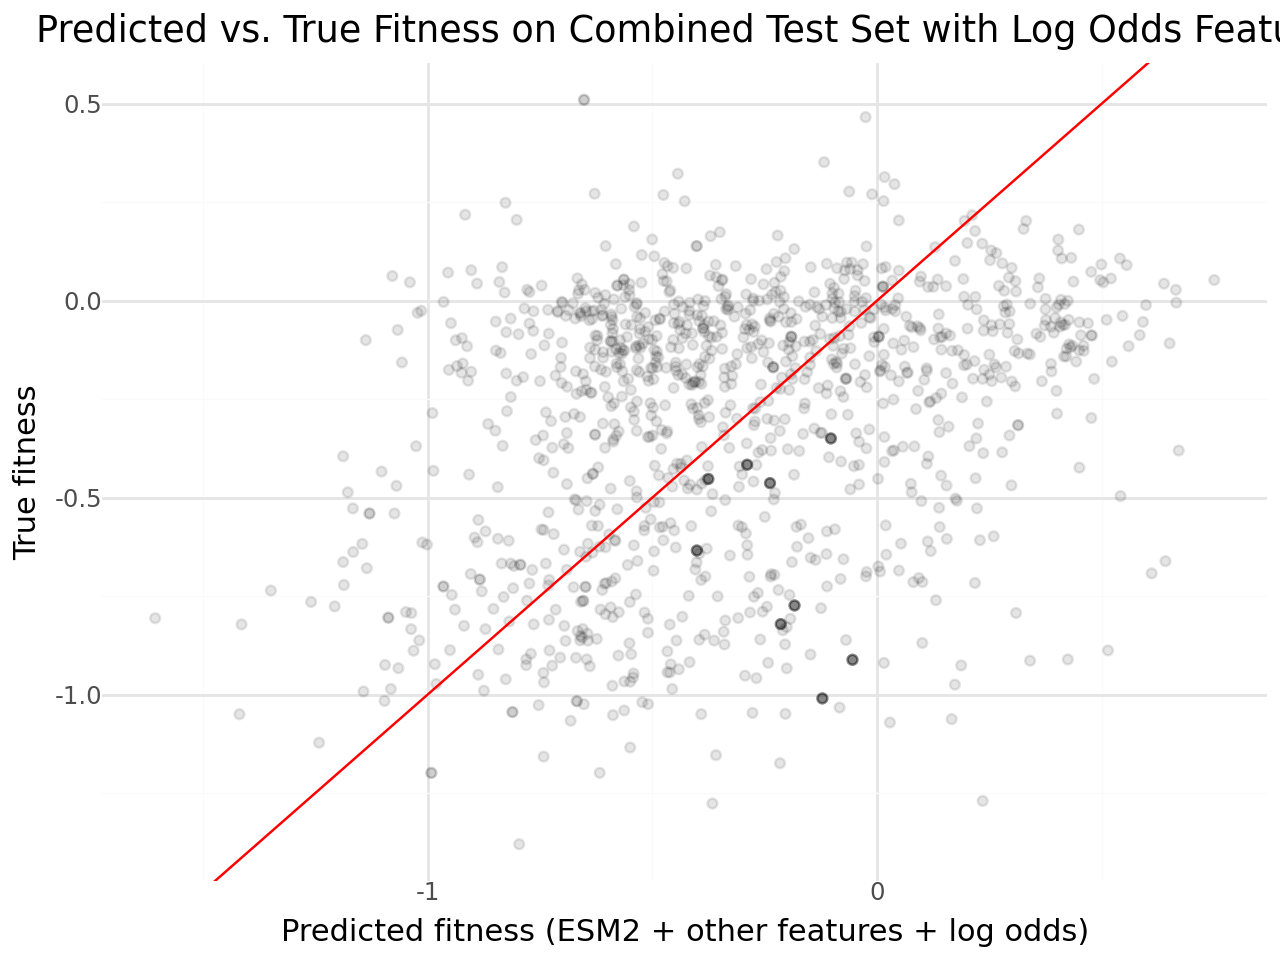

In [45]:
combined_plot_log_odds = (
    ggplot(pl.DataFrame({'y_true': y_test_combined_with_log_odds, 'y_pred': y_test_pred_combined_with_log_odds}), aes(x='y_pred', y='y_true'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness (ESM2 + other features + log odds)', y='True fitness', title='Predicted vs. True Fitness on Combined Test Set with Log Odds Feature')
    + theme_minimal()
)
display(combined_plot_log_odds)

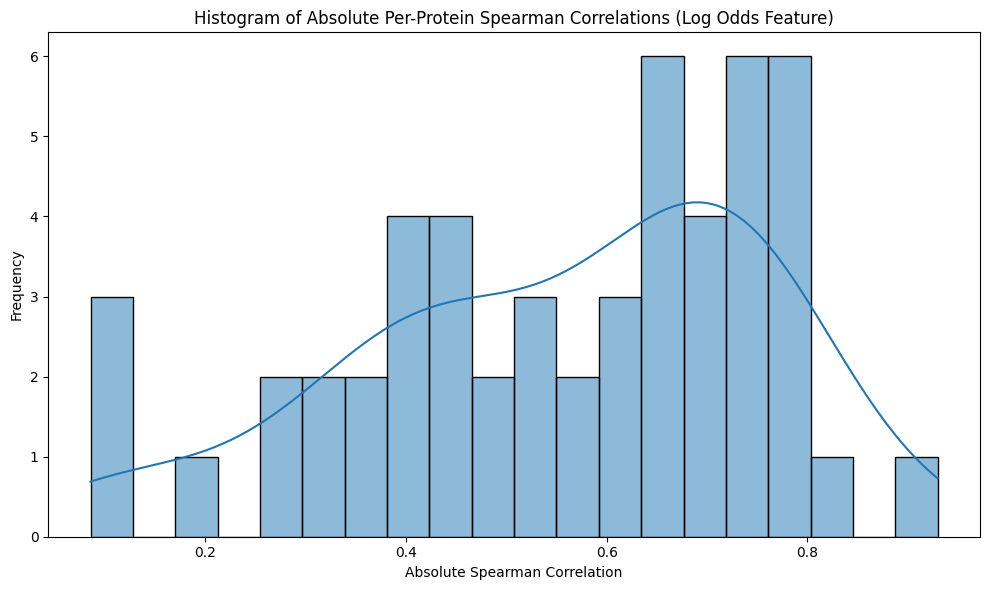

In [46]:

proteins_in_test_set_log_odds = groups_combined_with_log_odds_cleaned[test_idx_combined_with_log_odds]

protein_results_df_log_odds = pl.DataFrame({
    'uniprot_ID': proteins_in_test_set_log_odds,
    'true_fitness': y_test_combined_with_log_odds,
    'predicted_fitness': y_test_pred_combined_with_log_odds
})

def calculate_spearman_for_group(group_df: pl.DataFrame) -> float:
    if group_df.height < 2:
        return float('nan')
    return spearmanr(group_df['true_fitness'].to_numpy(), group_df['predicted_fitness'].to_numpy()).correlation

per_protein_spearman_df_list_log_odds = []
for group_name, group_df in protein_results_df_log_odds.group_by('uniprot_ID'):
    corr = calculate_spearman_for_group(group_df)
    per_protein_spearman_df_list_log_odds.append(pl.DataFrame({
        'uniprot_ID': [group_name],
        'spearman_correlation': [corr]
    }))

per_protein_spearman_log_odds = pl.concat(per_protein_spearman_df_list_log_odds)

per_protein_spearman_pd_log_odds = per_protein_spearman_log_odds.to_pandas()
per_protein_spearman_pd_log_odds['abs_spearman_correlation'] = per_protein_spearman_pd_log_odds['spearman_correlation'].abs().dropna()

plt.figure(figsize=(10, 6))
sns.histplot(per_protein_spearman_pd_log_odds['abs_spearman_correlation'], bins=20, kde=True)
plt.title('Histogram of Absolute Per-Protein Spearman Correlations (Log Odds Feature)')
plt.xlabel('Absolute Spearman Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



---

A bit of feature selection

In [47]:


y = y_combined_with_log_odds_cleaned
X = X_combined_with_log_odds_raw_cleaned

X = sm.add_constant(X)

model_ols = sm.OLS(y, X)
results_ols = model_ols.fit()

print(results_ols.summary())


p_values_array = results_ols.pvalues


feature_names = ['const'] + [f'x{i}' for i in range(1, len(p_values_array))]

p_values = pd.Series(p_values_array, index=feature_names)


p_values_features = p_values.drop('const')

sorted_p_values = p_values_features.sort_values(ascending=True)

top_5_features = sorted_p_values.head(5)

print("\nTop 5 Features by p-value (lowest first):\n")
for feature_name, p_value in top_5_features.items():
    if feature_name == 'x1281':
        print(f"Feature: Log Odds Score (p-value: {p_value:.4e})")
    else:

        print(f"Feature: ESM2 embedding dimension {feature_name[1:]} (p-value: {p_value:.4e})")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     4.120
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          3.59e-227
Time:                        11:57:44   Log-Likelihood:                 698.68
No. Observations:                4425   AIC:                             1167.
Df Residuals:                    3143   BIC:                             9365.
Df Model:                        1281                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2628      0.024    -10.844      0.0

In [48]:

p_values_array = results_ols.pvalues


feature_names = ['const'] + [f'x{i}' for i in range(1, len(p_values_array))]

p_values = pd.Series(p_values_array, index=feature_names)


p_values_features = p_values.drop('const')

sorted_p_values = p_values_features.sort_values(ascending=True)

top_5_features = sorted_p_values.head(5)

print("\nTop 5 Features by p-value (lowest first):\n")
for feature_name, p_value in top_5_features.items():
    if feature_name == 'x1281':
        print(f"Feature: Log Odds Score (p-value: {p_value:.4e})")
    else:

        print(f"Feature: ESM2 embedding dimension {feature_name[1:]} (p-value: {p_value:.4e})")



Top 5 Features by p-value (lowest first):

Feature: Log Odds Score (p-value: 1.3833e-11)
Feature: ESM2 embedding dimension 1211 (p-value: 1.5157e-02)
Feature: ESM2 embedding dimension 1134 (p-value: 1.8491e-02)
Feature: ESM2 embedding dimension 619 (p-value: 2.9101e-02)
Feature: ESM2 embedding dimension 422 (p-value: 2.9533e-02)


In [49]:
import pandas as pd
import requests
from io import StringIO

def download_gnomad_constraints():

    print("Downloading GnomaD data")

    url = "https://storage.googleapis.com/gcp-public-data--gnomad/release/4.1/constraint/gnomad.v4.1.constraint_metrics.tsv"

    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()

        df = pd.read_csv(StringIO(response.text), sep='\t')
        print(f"Download over : {len(df)} genes")
        return df

    except Exception as e:
        print(f"Error during the download : {e}")
        print("Trying with gnomAD v2.1.1...")

        url_v2 = "https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz"
        response = requests.get(url_v2, timeout=60)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text), sep='\t', compression='gzip')
        print(f"Download done : {len(df)} genes")
        return df

def add_loeuf_scores(data, gene_column='Gene Names (primary)', save_to_file=None):



      data = data.copy()

      if gene_column not in data.columns:
        raise ValueError(f"Column '{gene_column}' not found. Columns found: {data.columns.tolist()}")


      gnomad = download_gnomad_constraints()

      if 'gene' in gnomad.columns:
          gene_col = 'gene'
      elif 'gene_id' in gnomad.columns:
          gene_col = 'gene_id'
      else:
          gene_col = gnomad.columns[0]

      loeuf_cols = [col for col in gnomad.columns if 'lof' in col.lower() and ('oe' in col.lower() or 'upper' in col.lower())]

      if 'oe_lof_upper' in gnomad.columns:
          loeuf_col = 'oe_lof_upper'
      elif loeuf_cols:
          loeuf_col = loeuf_cols[0]
      else:
          raise ValueError("Impossible to find the LOEUF column in the gnomaD data")


      gnomad_simple = gnomad[[gene_col, loeuf_col]].copy()
      gnomad_simple.columns = ['gene', 'LOEUF']

      gnomad_simple = gnomad_simple.drop_duplicates(subset='gene', keep='first')
      print("\nMerge to data...")
      data_with_loeuf = data.merge(
          gnomad_simple,
          left_on=gene_column,
          right_on='gene',
          how='left'
      )
      if 'gene' in data_with_loeuf.columns and gene_column != 'gene':
          data_with_loeuf = data_with_loeuf.drop('gene', axis=1)
      data_with_loeuf['constraint_category'] = pd.cut(
          data_with_loeuf['LOEUF'],
          bins=[0, 0.35, 0.6, 1.0, float('inf')],
          labels=['Highly_constrained', 'Constrained', 'Moderately_tolerant', 'Tolerant']
      )

      matched = data_with_loeuf['LOEUF'].notna().sum()
      unmatched = data_with_loeuf['LOEUF'].isna().sum()

      print(f"\n=== Résultats ===")
      print(f"Genes with LOEUF found: {matched} ({matched/len(data)*100:.1f}%)")
      print(f"Genes without LOEUF: {unmatched} ({unmatched/len(data)*100:.1f}%)")

      if matched > 0:
          print(f"\nDistribution of the countraints:")
          print(data_with_loeuf['constraint_category'].value_counts())
          print(f"\ LOEUF statistics:")
          print(data_with_loeuf['LOEUF'].describe())


      return data_with_loeuf

<>:88: SyntaxWarning: invalid escape sequence '\ '
<>:88: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1059177250.py:88: SyntaxWarning: invalid escape sequence '\ '


In [50]:
data_with_loeuf = add_loeuf_scores(df.to_pandas())
data_with_loeuf

Download over : 211523 genes

Merge to data...

=== Résultats ===
Genes with LOEUF found: 545971 (89.9%)
Genes without LOEUF: 61110 (10.1%)

Distribution of the countraints:
constraint_category
Highly_constrained     267835
Constrained            128754
Moderately_tolerant    120600
Tolerant                24839
Name: count, dtype: int64
\ LOEUF statistics:
count    545971.000000
mean          0.434156
std           0.301709
min           0.000000
25%           0.206520
50%           0.353980
75%           0.631820
max           2.164700
Name: LOEUF, dtype: float64


,domain_ID,uniprot_ID,uniprot_ID_mutation,aa_seq,fitness,fitness_sigma,scaled_fitness,scaled_fitness_sigma,ESM1v_domain,RaSP,...,EVE_domain,rsasa,thermoMPNN,AlphaMissense,ESM1v_full-length,Organism,Gene Names (primary),Gene Names (synonym),LOEUF,constraint_category
0,A0A2R8Y422_PF00240_2,A0A2R8Y422,A0A2R8Y422_A28*,QIFVKTLMGKTITLEVELSDTIDNVK*KIQDKEGIPPDQQRLIFAG...,0.059234,0.009105,-0.422846,0.127517,NaN,NaN,...,NaN,41.3,NaN,NaN,None,Homo sapiens (Human),None,None,NaN,NaN
1,A0A2R8Y422_PF00240_2,A0A2R8Y422,A0A2R8Y422_A28C,QIFVKTLMGKTITLEVELSDTIDNVKCKIQDKEGIPPDQQRLIFAG...,0.091262,0.003764,0.025738,0.052712,-9.862297,0.944872,...,4.980072,41.3,-0.120494,0.3340,None,Homo sapiens (Human),None,None,NaN,NaN
2,A0A2R8Y422_PF00240_2,A0A2R8Y422,A0A2R8Y422_A28D,QIFVKTLMGKTITLEVELSDTIDNVKDKIQDKEGIPPDQQRLIFAG...,0.097388,0.003962,0.111544,0.055491,-8.525545,0.344768,...,3.766518,41.3,0.842978,0.2790,None,Homo sapiens (Human),None,None,NaN,NaN
3,A0A2R8Y422_PF00240_2,A0A2R8Y422,A0A2R8Y422_A28E,QIFVKTLMGKTITLEVELSDTIDNVKEKIQDKEGIPPDQQRLIFAG...,0.110153,0.007189,0.290325,0.100693,-7.011676,-0.044519,...,2.854782,41.3,0.355797,0.2014,None,Homo sapiens (Human),None,None,NaN,NaN
4,A0A2R8Y422_PF00240_2,A0A2R8Y422,A0A2R8Y422_A28F,QIFVKTLMGKTITLEVELSDTIDNVKFKIQDKEGIPPDQQRLIFAG...,0.089583,0.003577,0.002225,0.050106,-10.680157,-0.423373,...,5.208206,41.3,0.118878,0.3648,None,Homo sapiens (Human),None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607076,Q9Y6V0_PF05715_1058,Q9Y6V0,Q9Y6V0_W1104S,TCPLCKTELNIGSKDPPNFNTCTECKNQVCNLCGFNPTPHLTEIQE...,0.105455,0.012201,-0.029589,0.137867,-5.345161,5.397289,...,8.343338,11.8,2.117514,0.9588,-12.64865,Homo sapiens (Human),PCLO,ACZ KIAA0559,0.15118,Highly_constrained
607077,Q9Y6V0_PF05715_1058,Q9Y6V0,Q9Y6V0_W1104T,TCPLCKTELNIGSKDPPNFNTCTECKNQVCNLCGFNPTPHLTEIQE...,0.090854,0.015305,-0.194564,0.172938,-5.214868,4.558003,...,9.494637,11.8,1.988062,0.9647,-14.00641,Homo sapiens (Human),PCLO,ACZ KIAA0559,0.15118,Highly_constrained
607078,Q9Y6V0_PF05715_1058,Q9Y6V0,Q9Y6V0_W1104V,TCPLCKTELNIGSKDPPNFNTCTECKNQVCNLCGFNPTPHLTEIQE...,0.115816,0.010449,0.087485,0.118070,-4.870904,3.148088,...,8.973549,11.8,1.270481,0.9512,-13.55418,Homo sapiens (Human),PCLO,ACZ KIAA0559,0.15118,Highly_constrained
607079,Q9Y6V0_PF05715_1058,Q9Y6V0,Q9Y6V0_W1104Y,TCPLCKTELNIGSKDPPNFNTCTECKNQVCNLCGFNPTPHLTEIQE...,0.064475,0.022245,-0.492635,0.251357,-4.390252,1.411740,...,8.418221,11.8,0.628391,0.8258,-11.89384,Homo sapiens (Human),PCLO,ACZ KIAA0559,0.15118,Highly_constrained


In [51]:
coeff_dfs = []
trained_models = {
    "baseline": ridge_model_refined ,
    "with_other_coeffs": ridge_model_combined,
    "with_L2": ridge_model_combined_with_l2,
    "with_log_odds": ridge_model_combined_with_log_odds,
}
num_esm2_features = X_train_refined.shape[1]
esm2_feature_names = [f'ESM2_dim_{i}' for i in range(num_esm2_features)]

feature_names_map = {
    "baseline": esm2_feature_names,
    "with_other_coeffs": esm2_feature_names + ['AlphaMissense', 'ESM1v_domain', 'EVE_domain'],
    "with_L2": esm2_feature_names + ['L2_distance'],
    "with_log_odds": esm2_feature_names + ['Log_Odds_Score'],
}
all_features = sorted(list(set().union(*feature_names_map.values())))

for model_id, model in trained_models.items():
    current_model_feature_names = feature_names_map[model_id]
    df_for_stuff = pd.DataFrame(
        0,
        index=[model_id],
        columns=all_features
    )
    df_for_stuff.loc[model_id, current_model_feature_names] = model.coef_.ravel()
    coeff_dfs.append(df_for_stuff)

coeff_df = pd.concat(coeff_dfs)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
/tmp/ipython-input-2881163218.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.015010274684705083' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-2881163218.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009609794958131534' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-2881163218.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010451085348367885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-2881163218.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

In [52]:
coeff_df

,AlphaMissense,ESM1v_domain,ESM2_dim_0,ESM2_dim_1,ESM2_dim_10,ESM2_dim_100,ESM2_dim_1000,ESM2_dim_1001,ESM2_dim_1002,ESM2_dim_1003,...,ESM2_dim_993,ESM2_dim_994,ESM2_dim_995,ESM2_dim_996,ESM2_dim_997,ESM2_dim_998,ESM2_dim_999,EVE_domain,L2_distance,Log_Odds_Score
baseline,0.000000,0.000000,-0.005762,0.004812,-0.018506,-0.015786,0.016850,-0.013303,0.024312,-0.006463,...,-0.005787,0.028181,-0.000532,0.020810,-0.012681,-0.009442,-0.009266,0.000000,0.000000,0.000000
with_other_coeffs,-0.024928,0.101323,-0.001050,-0.005272,-0.022752,-0.003881,0.011700,-0.011167,0.011586,0.011898,...,-0.018685,0.014390,-0.000162,0.015675,-0.008295,-0.009988,-0.006157,-0.088347,0.000000,0.000000
with_L2,0.000000,0.000000,-0.004173,0.002707,-0.019032,-0.015444,0.019840,-0.017632,0.026775,-0.003197,...,-0.006312,0.026037,-0.000115,0.021100,-0.011197,-0.010315,-0.009650,0.000000,-0.052871,0.000000
with_log_odds,0.000000,0.000000,-0.016172,0.001164,-0.021150,-0.019186,0.016922,-0.015385,0.021869,0.005040,...,-0.007632,0.026530,-0.000762,0.026689,-0.013346,-0.002990,0.000944,0.000000,0.000000,0.047048


In [53]:
def calculate_per_protein_spearman(y_true, y_pred, groups, model_name):
    protein_results_df = pl.DataFrame({
        'uniprot_ID': groups,
        'true_fitness': y_true,
        'predicted_fitness': y_pred
    })

    per_protein_spearman_df_list = []
    for group_name, group_df in protein_results_df.group_by('uniprot_ID'):
        if group_df.height < 2:
            corr = float('nan')
        else:
            corr = spearmanr(group_df['true_fitness'].to_numpy(), group_df['predicted_fitness'].to_numpy()).correlation
        per_protein_spearman_df_list.append(pl.DataFrame({
            'uniprot_ID': [group_name],
            'spearman_correlation': [corr],
            'model': [model_name]
        }))

    per_protein_spearman = pl.concat(per_protein_spearman_df_list)
    per_protein_spearman_pd = per_protein_spearman.to_pandas()
    per_protein_spearman_pd['abs_spearman_correlation'] = per_protein_spearman_pd['spearman_correlation'].abs()
    return per_protein_spearman_pd.dropna(subset=['abs_spearman_correlation'])


y_test_pred_refined = ridge_model_refined.predict(X_test_refined)
groups_refined_test = groups_refined[test_idx_refined]

per_protein_spearman_refined_df = calculate_per_protein_spearman(
    y_test_refined, y_test_pred_refined, groups_refined_test, "ESM2 Baseline"
)

print("Calculated per-protein Spearman correlations for the baseline model.")

Calculated per-protein Spearman correlations for the baseline model.


In [54]:
groups_combined_test = groups_combined[test_idx_combined]
per_protein_spearman_combined_df = calculate_per_protein_spearman(
    y_test_combined, y_test_pred_combined, groups_combined_test, "ESM2 + Other Features"
)

print("Calculated per-protein Spearman correlations for the 'ESM2 + Other Features' model.")

Calculated per-protein Spearman correlations for the 'ESM2 + Other Features' model.


In [55]:
groups_l2_test = groups_combined_with_l2[test_idx_combined_with_l2]
per_protein_spearman_l2_df = calculate_per_protein_spearman(
    y_test_combined_with_l2, y_test_pred_combined_with_l2, groups_l2_test, "ESM2 + L2 Distance"
)

print("Calculated per-protein Spearman correlations for the 'ESM2 + L2 Distance' model.")

Calculated per-protein Spearman correlations for the 'ESM2 + L2 Distance' model.


In [56]:
groups_log_odds_test = groups_combined_with_log_odds_cleaned[test_idx_combined_with_log_odds]
per_protein_spearman_log_odds_df = calculate_per_protein_spearman(
    y_test_combined_with_log_odds, y_test_pred_combined_with_log_odds, groups_log_odds_test, "ESM2 + Log Odds"
)

print("Calculated per-protein Spearman correlations for the 'ESM2 + Log Odds' model.")

Calculated per-protein Spearman correlations for the 'ESM2 + Log Odds' model.


In [57]:
all_per_protein_spearman_df = pd.concat([
    per_protein_spearman_refined_df,
    per_protein_spearman_combined_df,
    per_protein_spearman_l2_df,
    per_protein_spearman_log_odds_df
])

print("Combined Per-Protein Spearman Correlations:")
display(all_per_protein_spearman_df.head())

Combined Per-Protein Spearman Correlations:


,uniprot_ID,spearman_correlation,model,abs_spearman_correlation
0,[Q13263],0.501754,ESM2 Baseline,0.501754
1,[Q9BYW2],0.512900,ESM2 Baseline,0.512900
2,[Q6XZF7],0.594758,ESM2 Baseline,0.594758
3,[O95267],0.644269,ESM2 Baseline,0.644269
4,[Q03164],-0.358554,ESM2 Baseline,0.358554


In [58]:
def extract_uniprot_id_from_nested(val):
    if isinstance(val, list) and len(val) > 0:
        val = val[0]
    if isinstance(val, tuple) and len(val) > 0:
        val = val[0]
    if isinstance(val, np.ndarray) and val.size > 0:
        val = val.item()
    return str(val)

all_per_protein_spearman_df['uniprot_ID'] = all_per_protein_spearman_df['uniprot_ID'].apply(extract_uniprot_id_from_nested)
data_with_loeuf['uniprot_ID'] = data_with_loeuf['uniprot_ID'].apply(extract_uniprot_id_from_nested)

merged_df = pd.merge(
    all_per_protein_spearman_df,
    data_with_loeuf[['uniprot_ID', 'LOEUF', 'constraint_category']].drop_duplicates(subset=['uniprot_ID']),
    on='uniprot_ID',
    how='left'
)

print("\nMerged DataFrame with LOEUF data:")
display(merged_df.head())


Merged DataFrame with LOEUF data:


,uniprot_ID,spearman_correlation,model,abs_spearman_correlation,LOEUF,constraint_category
0,Q13263,0.501754,ESM2 Baseline,0.501754,0.093951,Highly_constrained
1,Q9BYW2,0.512900,ESM2 Baseline,0.512900,0.124240,Highly_constrained
2,Q6XZF7,0.594758,ESM2 Baseline,0.594758,0.592420,Constrained
3,O95267,0.644269,ESM2 Baseline,0.644269,0.364920,Constrained
4,Q03164,-0.358554,ESM2 Baseline,0.358554,0.040958,Highly_constrained


In [59]:
merged_df["LOEUF_bin"] = pd.qcut(
    merged_df["LOEUF"],
    q=4,
    labels=["Q1_low_constraint", "Q2", "Q3", "Q4_high_constraint"]
)
performance_by_loeuf = (
    merged_df
    .groupby("LOEUF_bin")["abs_spearman_correlation"]
    .agg(["mean", "std", "count"])
)

print("Model performance stratified by LOEUF:")
display(performance_by_loeuf)

Model performance stratified by LOEUF:


/tmp/ipython-input-2723721637.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,mean,std,count
LOEUF_bin,,,
Q1_low_constraint,0.474775,0.155001,48
Q2,0.552358,0.219657,48
Q3,0.569460,0.193584,48
Q4_high_constraint,0.595852,0.237828,48


In [60]:
average_spearman_per_model = merged_df.groupby('model')['abs_spearman_correlation'].mean().reset_index()

print("Average Absolute Spearman Correlation for Each Model:")
display(average_spearman_per_model.sort_values(by='abs_spearman_correlation', ascending=False))


Average Absolute Spearman Correlation for Each Model:


,model,abs_spearman_correlation
2,ESM2 + Other Features,0.606320
1,ESM2 + Log Odds,0.555661
0,ESM2 + L2 Distance,0.517826
3,ESM2 Baseline,0.513449


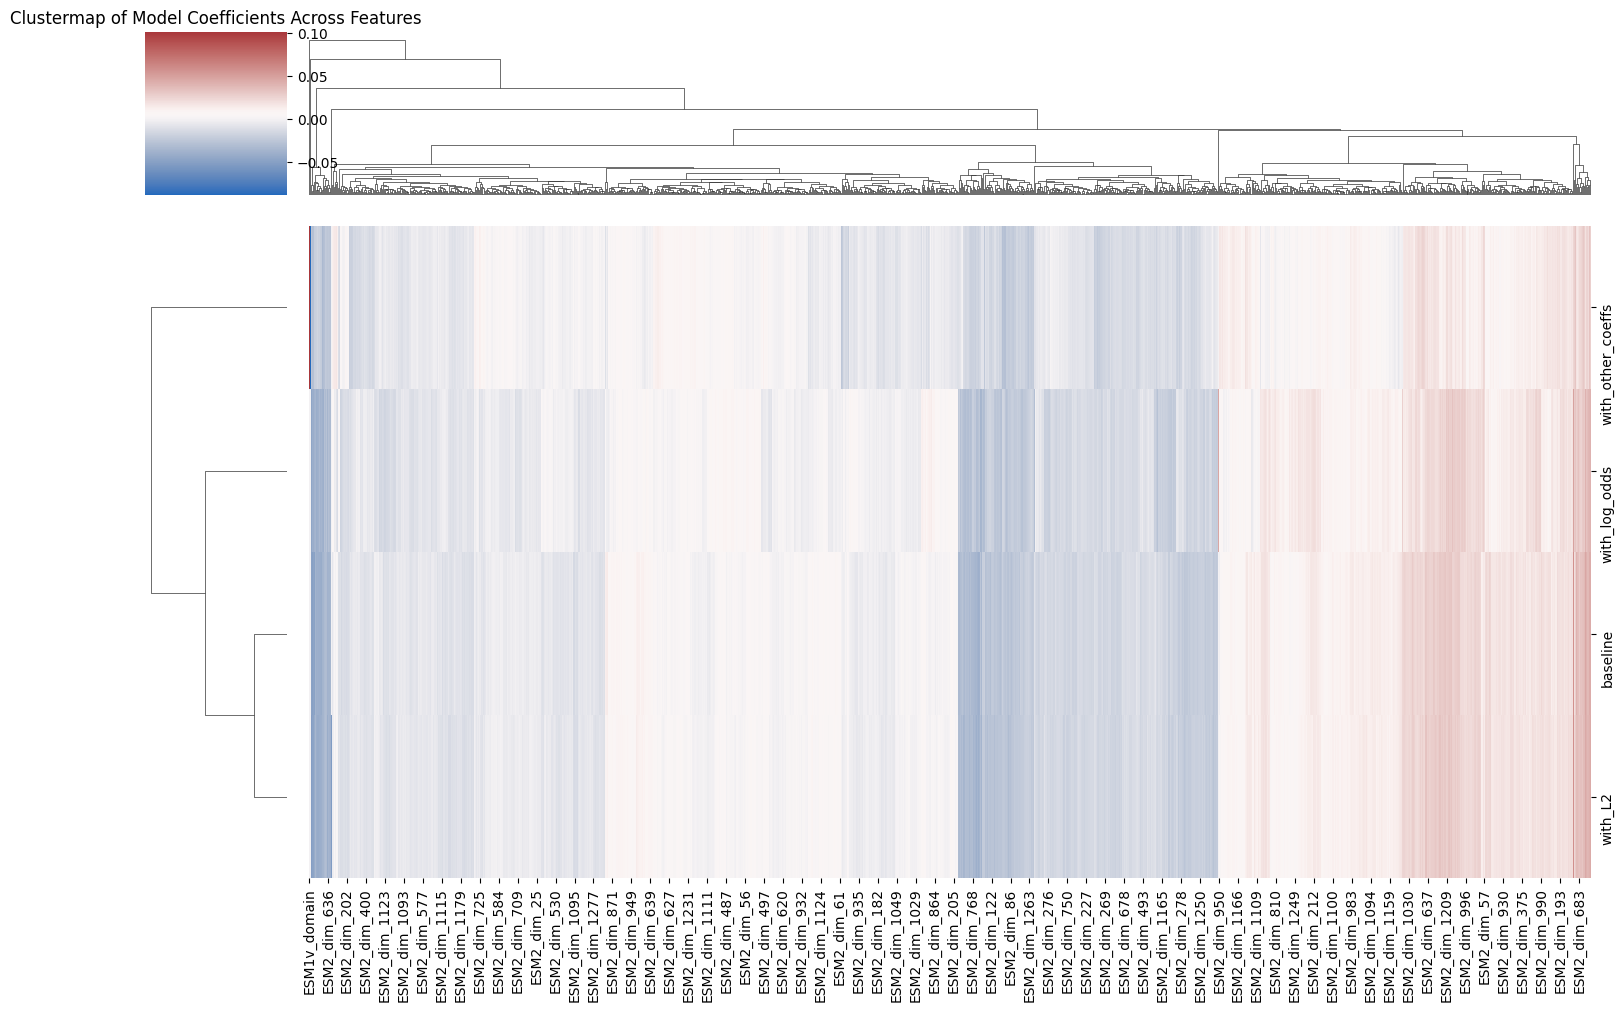

In [61]:

sns.clustermap(coeff_df, cmap='vlag', figsize=(15, 10), dendrogram_ratio=(0.1, 0.2), cbar_pos=(0.02, 0.8, 0.03, 0.15))
plt.title('Clustermap of Model Coefficients Across Features')
plt.tight_layout()
plt.show()


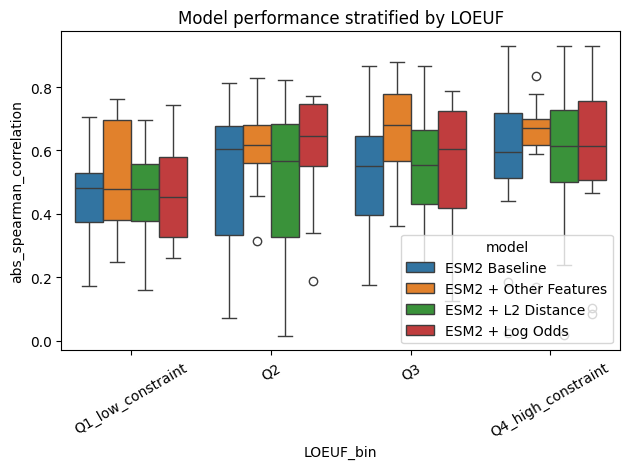

In [62]:
sns.boxplot(
    data=merged_df,
    x="LOEUF_bin",
    y="abs_spearman_correlation",
    hue="model"
)
plt.xticks(rotation=30)
plt.title("Model performance stratified by LOEUF")
plt.tight_layout()
plt.show()

In [63]:
# =============================================================================
# 🟢 SECTION 1: DELTA CHARGE (ELECTRICAL CHARGE DIFFERENCE) CALCULATION
# =============================================================================
import pandas as pd
import numpy as np

# 1. Amino Acid Charge Map (pH 7.4)
AA_CHARGE_MAP = {
    'A': 0, 'C': 0, 'D': -1, 'E': -1, 'F': 0,
    'G': 0, 'H': 0.1, 'I': 0, 'K': 1, 'L': 0,
    'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 1,
    'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0,
    '*': 0
}

def calculate_delta_charge(mutation_str):
    """
    Calculates the charge difference between Mutant and Wildtype.
    E.g.: If R (+1) -> E (-1), the result is -2.
    """
    try:
        # Format: "UNIPROTID_MUTATION" (e.g.: Q8N157_E17D)
        if "_" in str(mutation_str):
            mutation_part = mutation_str.split("_")[1]
        else:
            mutation_part = str(mutation_str)

        # First char (Old/Wildtype) and Last char (New/Mutant)
        wt_aa = mutation_part[0]
        mut_aa = mutation_part[-1]

        # Get charges
        charge_wt = AA_CHARGE_MAP.get(wt_aa, 0)
        charge_mut = AA_CHARGE_MAP.get(mut_aa, 0)

        return charge_mut - charge_wt

    except Exception:
        return 0.0

print("\n⚡ Calculating Delta Charge...")

# Converting Polars DataFrame to Pandas (Because .apply is easier in Pandas)
# 'combined_data_with_log_odds_cleaned_df' is the clean Polars data from your previous steps
if hasattr(combined_data_with_log_odds_cleaned_df, 'to_pandas'):
    df_for_charge = combined_data_with_log_odds_cleaned_df.to_pandas()
else:
    df_for_charge = combined_data_with_log_odds_cleaned_df.copy()

# Apply calculation
df_for_charge['delta_charge'] = df_for_charge['uniprot_ID_mutation'].apply(calculate_delta_charge)

print(f"✅ Calculation complete! Examples:")
print(df_for_charge[['uniprot_ID_mutation', 'delta_charge']].head())


⚡ Calculating Delta Charge...
✅ Calculation complete! Examples:
  uniprot_ID_mutation  delta_charge
0        A1X283_E183G           1.0
1        A1X283_G208V           0.0
2        A1X283_I182Y           0.0
3        A1X283_K165W          -1.0
4        A1X283_L206K           1.0


In [64]:
#Delta_Charge: Elektrik yükü değişti mi? (+1 -> -1 çok tehlikelidir).

In [65]:
#top½50 protein yerine random seçerek dene

In [66]:
#cross validation

In [ ]:
# =============================================================================
# 🚀 GRAND FINAL: XGBoost + Delta Charge + LOEUF (All-in Approach)
# =============================================================================
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n🚀 STARTING FINAL MODEL: XGBoost (Including LOEUF)...")

# --- A. ADDING LOEUF DATA ---
# We previously created the 'data_with_loeuf' table.
# We will extract LOEUF scores from there and add them to training.

# 1. Prepare training data (with calculated Delta Charge)
if hasattr(df_for_charge, 'to_pandas'):
     df_final = df_for_charge.to_pandas().copy()
else:
     df_final = df_for_charge.copy()

# 2. Extract UniProt ID (Mapping key)
df_final['uniprot_ID'] = df_final['uniprot_ID_mutation'].apply(lambda x: x.split('_')[0])

# 3. Map LOEUF Scores
# Extract only ID and LOEUF from 'data_with_loeuf' table and create a dictionary (for speed)
if 'data_with_loeuf' in locals():
    # There might be multiple rows in the LOEUF table, clean using drop_duplicates
    loeuf_map = data_with_loeuf[['uniprot_ID', 'LOEUF']].drop_duplicates(subset='uniprot_ID').set_index('uniprot_ID')['LOEUF'].to_dict()

    # Mapping
    df_final['LOEUF'] = df_final['uniprot_ID'].map(loeuf_map)

    # ⚠️ IMPORTANT: There might be proteins with missing LOEUF values (NaN).
    # Fill them with -1 so the model understands "No score available".
    print(f"Number of NaNs before adding LOEUF: {df_final['LOEUF'].isna().sum()}")
    df_final['LOEUF'] = df_final['LOEUF'].fillna(-1)
    print("LOEUF successfully added.")
else:
    print("⚠️ WARNING: 'data_with_loeuf' not found! LOEUF could not be added. Continuing code...")
    df_final['LOEUF'] = -1 # Create empty column to prevent errors

# --- B. CREATING FEATURE MATRICES (X) ---

# 1. ESM2 Embeddings
X_esm2 = X_refined_final_embeddings_cleaned

# 2. External Features (AlphaMissense, EVE, ESM1v)
X_external = df_final[['AlphaMissense', 'ESM1v_domain', 'EVE_domain']].to_numpy()

# 3. Log Odds (BLOSUM62)
X_log_odds = df_final[['log_odds_score']].to_numpy()

# 4. Delta Charge
X_charge = df_final[['delta_charge']].to_numpy()

# 5. NEW: LOEUF Score
X_loeuf = df_final[['LOEUF']].to_numpy()

# 6. STACK ALL FEATURES
X_final = np.hstack([X_esm2, X_external, X_log_odds, X_charge, X_loeuf])

# Target Variable and Groups
y_final = df_final['scaled_fitness'].to_numpy()
groups = df_final['uniprot_ID'].to_numpy()

print(f"✅ Training Matrix Ready! Shape: {X_final.shape}")

# --- C. CROSS VALIDATION LOOP ---

gkf = GroupKFold(n_splits=5)
fold = 1
r2_scores = []
spearman_scores = []

# Feature names for plotting
feature_names = [f"ESM2_{i}" for i in range(1280)] + ['AlphaMissense', 'ESM1v', 'EVE', 'BLOSUM62', 'Delta_Charge', 'LOEUF']

for train_idx, test_idx in gkf.split(X_final, y_final, groups=groups):
    print(f"\n🔄 Running Fold {fold}/5...")

    X_train_cv, X_test_cv = X_final[train_idx], X_final[test_idx]
    y_train_cv, y_test_cv = y_final[train_idx], y_final[test_idx]

    # Initialize Model
    model_xgb = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )

    # Train
    model_xgb.fit(X_train_cv, y_train_cv)

    # Predict
    y_pred_cv = model_xgb.predict(X_test_cv)

    # Score
    r2 = r2_score(y_test_cv, y_pred_cv)
    spearman = spearmanr(y_test_cv, y_pred_cv).correlation

    print(f"   👉 Fold {fold} Result -> R2: {r2:.4f} | Spearman: {spearman:.4f}")

    r2_scores.append(r2)
    spearman_scores.append(spearman)
    fold += 1

# --- D. FINAL REPORT AND PLOT ---

print("\n" + "="*50)
print(f"🏆 AVERAGE RESULTS (5-Fold CV)")
print(f"==================================================")
print(f"✅ Average R2:       {np.mean(r2_scores):.4f}  (± {np.std(r2_scores):.4f})")
print(f"✅ Average Spearman: {np.mean(spearman_scores):.4f}  (± {np.std(spearman_scores):.4f})")
print("="*50)

# Feature Importance Plot
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(12, 8))
plt.title('Top 15 Most Important Features')
plt.barh(range(len(indices)), importances[indices], color='darkblue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


🚀 STARTING FINAL MODEL: XGBoost (Including LOEUF)...
Number of NaNs before adding LOEUF: 336
LOEUF successfully added.
✅ Training Matrix Ready! Shape: (5288, 1286)

🔄 Running Fold 1/5...
